Домашнее задание №0
====



In [1]:
# Импортируем нужные нам библиотеки
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn; seaborn.set()
from sklearn.metrics import mean_absolute_error,mean_squared_error,r2_score
import numpy as np
import matplotlib.dates as mdates
import seaborn as sns
import matplotlib
# Use seaborn style defaults and set the default figure size
sns.set(rc={'figure.figsize':(15, 10)})
sns.set(font_scale=2)
sns.set_style("whitegrid")

In [2]:
# Загружаем датасет, с которым мы будем работать
df = pd.read_csv('../datatest/bike-sharing.csv')

In [3]:
df.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,9.84,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,9.02,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,9.02,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,9.84,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,9.84,0.2879,0.75,0.0,0,1,1


Задание
====

* Выбрать самостоятельно уровень агрегации (день, неделя, месяц, год), а так же функцию агрегации (среднее, сумма, максимум). 
* Построить базовую наивную модель





In [4]:
def test_pred_plot(df_test, real_col, pred_col): 
    fig, ax = plt.subplots()
    ax.plot(df_test[real_col], linewidth = 2, color='black',label = 'Original')
    ax.plot(df_test[pred_col], linewidth = 1, color = 'blue', label =' Predictions')
    ax.xaxis.set_major_locator(mdates.WeekdayLocator(byweekday=mdates.MONDAY))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'));
    for label in ax.get_xticklabels(which='major'):
        label.set(rotation=45, horizontalalignment='right')
    ax.legend()
    plt.show()

In [16]:
def calc_metrics(df_test, real_col, pred_col): 
    print(f'>>>> {pred_col}')
    mae = np.round(mean_absolute_error(df_test[real_col], df_test[pred_col]),2)
    mse = np.round(mean_squared_error(df_test[real_col], df_test[pred_col]),2)
    r2 = np.round(r2_score(df_test[real_col], df_test[pred_col]),2)
    print(f'MAE = {mae}')
    print(f'MSE = {mse}')
    print(f'R2 = {r2}')

In [17]:
df['dteday'] = pd.to_datetime(df['dteday'])
df_daily_sum = df.groupby('dteday').sum()[['cnt']]

In [18]:
### Уровень аггрегации - недельный 
### Функция аггрегации - сумма 

df_week_sum = df_daily_sum.resample('W-MON').sum()

### удалим последнюю неделю т.к. она состоит из одного дня 
df_week_sum = df_week_sum[:-1]

<AxesSubplot:title={'center':'Weekly sum of bike users'}, xlabel='dteday'>

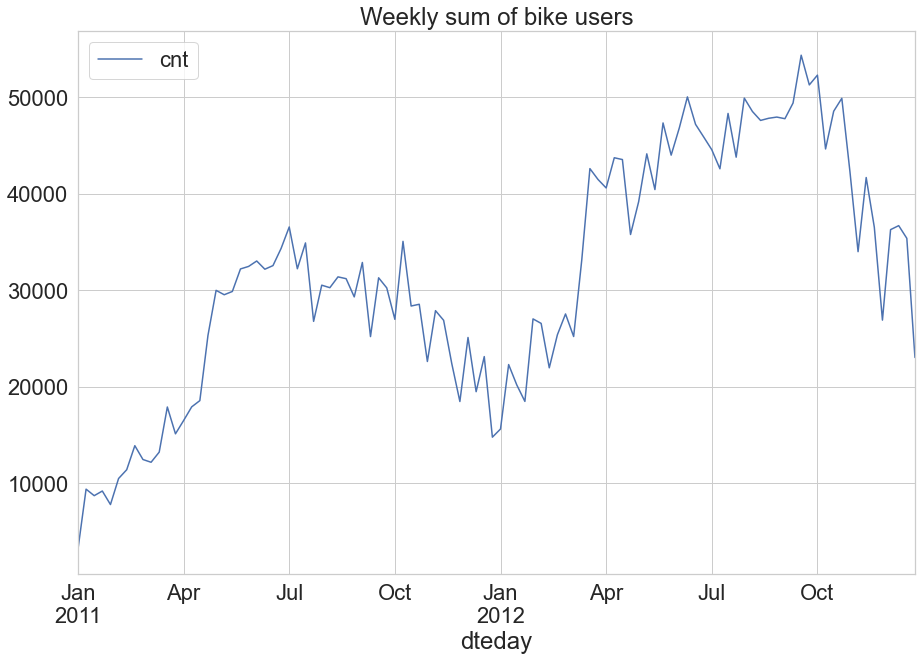

In [19]:
df_week_sum.plot(title='Weekly sum of bike users')

In [20]:
### разделим датасет на train/test для проверки baseline модели в соотношении 80/20  
weeks_to_split = int(np.floor(df_week_sum.shape[0] * 0.2))
train, test = df_week_sum[:-weeks_to_split], df_week_sum[-weeks_to_split:]

### Варианты baseline:

1. **Среднее за весь "тренировочный" период**  

2. **Среднее с начала 2012 года (из тренировочного датасета)**  

3. **Прошлогодние данные за аналогичный период**

4. **То среднее из п.1 или п.2 которое покажет себя лучше + недельные коэф-ты сезонности за 2011 год**

In [21]:
# расчет baseline #1
test = test.assign(pred_1 = train['cnt'].mean())
# расчет baseline #2
test = test.assign(pred_2 = train['2012':]['cnt'].mean())
# расчет baseline #3
test['pred_3'] = train[:'2011'][-weeks_to_split:].values

# расчет данных для baseline #4
train_2011 = train[:'2011']
train_2011['week_num'] = train_2011.index.week
week_coef = train_2011.groupby('week_num').cnt.mean() / train_2011.cnt.mean()
week_coef_dict = dict(week_coef.reset_index().values)
test['week_num'] = test.index.week
test['week_coef'] = test['week_num'].map(week_coef_dict)

/var/folders/n0/kspqb1_558b47mvmpbbt5n880000gn/T/ipykernel_29439/2787415502.py:10: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series.  To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  train_2011['week_num'] = train_2011.index.week
/var/folders/n0/kspqb1_558b47mvmpbbt5n880000gn/T/ipykernel_29439/2787415502.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_2011['week_num'] = train_2011.index.week
/var/folders/n0/kspqb1_558b47mvmpbbt5n880000gn/T/ipykernel_29439/2787415502.py:13: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week 

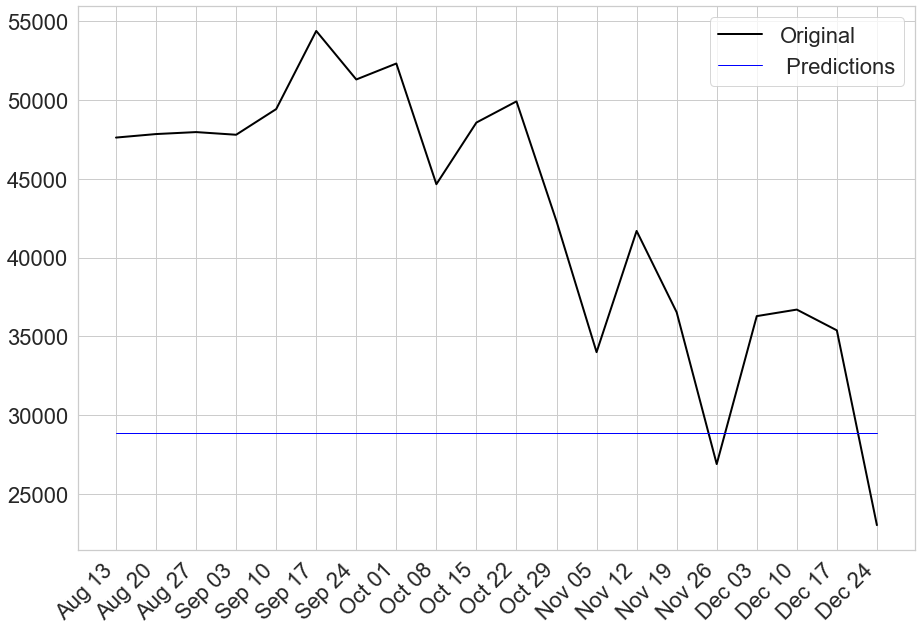

>>>> pred_1
MAE = 14627.08
MSE = 262832642.58
R2 = -2.69


In [22]:
test_pred_plot(test, 'cnt', 'pred_1')
calc_metrics(test, 'cnt', 'pred_1')

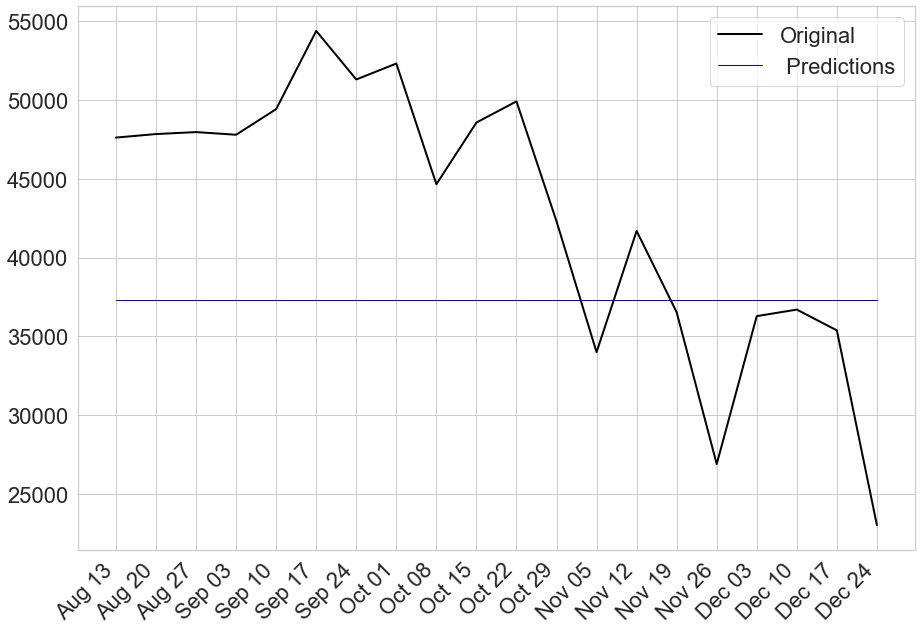

>>>> pred_2
MAE = 8646.43
MSE = 100425911.89
R2 = -0.41


In [23]:
test_pred_plot(test, 'cnt', 'pred_2')
calc_metrics(test, 'cnt', 'pred_2')

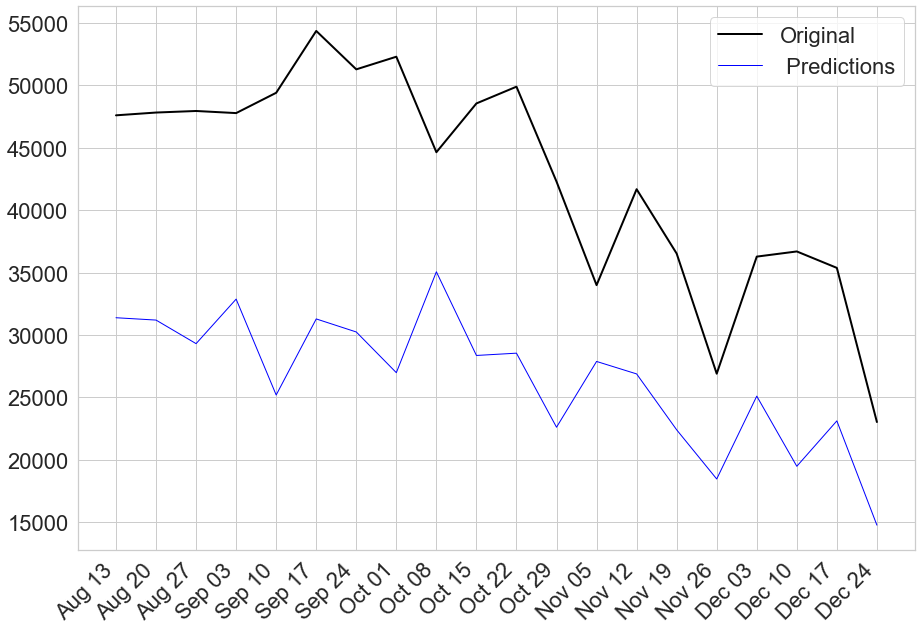

>>>> pred_3
MAE = 16162.05
MSE = 291078432.35
R2 = -3.09


In [24]:
test_pred_plot(test, 'cnt', 'pred_3')
calc_metrics(test, 'cnt', 'pred_3')

In [25]:
test['pred_4'] = test['pred_2'] * test['week_coef']

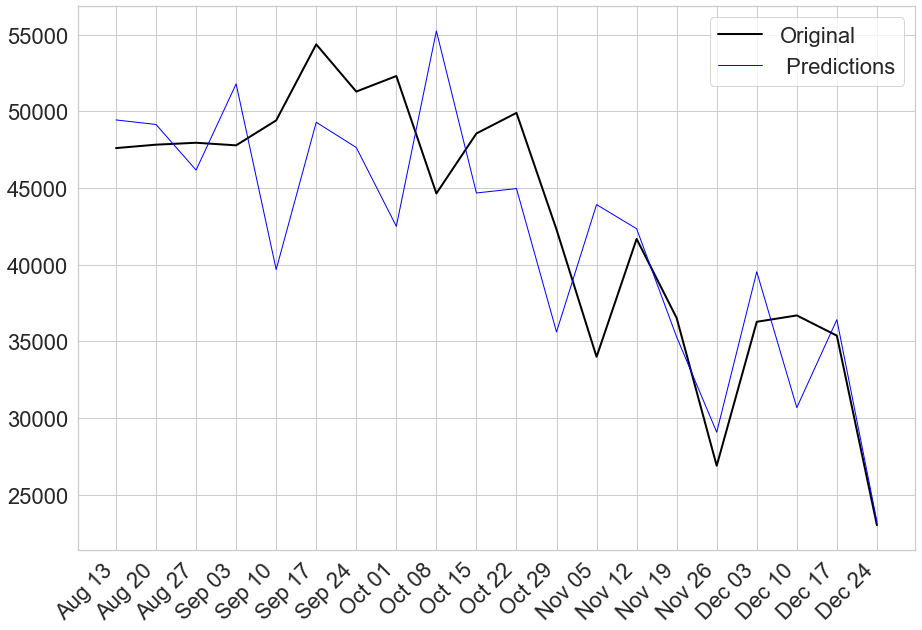

>>>> pred_4
MAE = 4390.4
MSE = 30152434.06
R2 = 0.58


In [26]:
test_pred_plot(test, 'cnt', 'pred_4')
calc_metrics(test, 'cnt', 'pred_4')

### Вывод: 

Наилучшие значения метрик показала baseline-модель №4 с умножением коэффициентов недельной сезонности на среднее значение переменной за 2012 год (предыдущие 8 месяцев). 